In [11]:
from script import * 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

# PCA and Random Forest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Logistic Regression:
from sklearn.linear_model import LogisticRegression

# CNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import trange, tqdm

#  Data Loading and Preview

In [12]:
data = np.float64(np.load('MNIST_data.npy'))
data = data/255
labels = np.load('MNIST_labels.npy')

Preview the first 20 digit images:

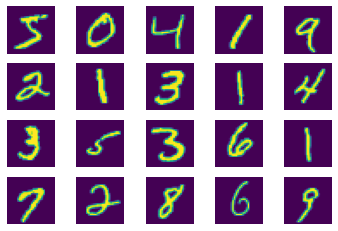

In [ ]:
preview(20, data)

We split the entire data set into three parts: a training set, a validation set and a test set. For each method, we use the training set and validation set to train model and perform model selections (in particular tuning hyper-parameters). After that, we select the best model for each method and use the test set to compare performance of different models.

In [ ]:
Xtrain = data[0:50000]
ytrain = labels[0:50000]
Xval = data[50000:60000]
yval = labels[50000:60000]
Xtest = data[60000:70000]
ytest = labels[60000:70000]

print(f'The number of pixel variables is {ytrain.shape[0]}')
print(f"The number of records in the training set: {Xtrain.shape[0]}")
print(f"The number of records in the validation set: {Xval.shape[0]}")
print(f"The number of records in the test set: {Xtest.shape[0]}")

The number of pixel variables is 50000
The number of records in the training set: 50000
The number of records in the validation set: 10000
The number of records in the test set: 10000


To see how different digits have different images, we choose two similar digits to visualize: $1$ and $7$.   
The images are shown below:

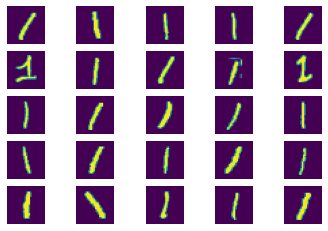

In [ ]:
digit_image(1,Xtrain,ytrain)

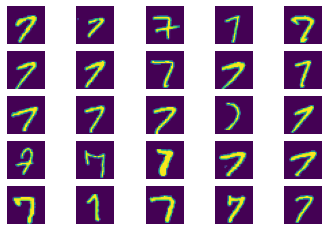

In [ ]:
digit_image(7,Xtrain,ytrain)

# Model training and parameter tuning

### Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100,random_state=1234)
rf.fit(Xtrain, ytrain)
# test on validation set
pred = rf.predict(Xval)
correct = accuracy_score(yval, pred)
print(f'A random forest classifier without using PCA has accuracy {correct}.')

A random forest classifier without using PCA has accuracy 0.9685


First of all, we select the optimal $n$ (number of trees) on validation set:

In [ ]:
error = []
N = [50,100,200,300,400,500]
for n in N:
    rf = RandomForestClassifier(n_estimators=n,random_state=1234)
    rf.fit(Xtrain, ytrain)
    pred = rf.predict(Xval)
    correct = accuracy_score(yval, pred)
    error.append(1-correct)

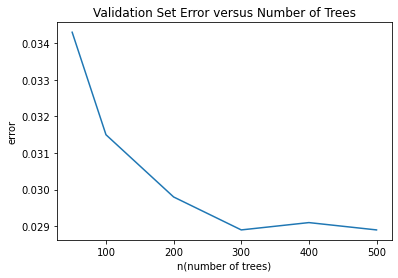

In [ ]:
plt.plot(N,error)
plt.xlabel('n(number of trees)')
plt.ylabel('error')
plt.title("Validation Set Error versus Number of Trees")
plt.show()

From the graph above, using 300 trees yields with the lowest error rate. The following is the model's performance result:

error rate on validation set: 2.89%

Confusion Matrix:
[[ 970    1    0    0    0    1    4    1    2    1]
 [   0 1121    3    3    0    1    4    1    2    0]
 [   6    0 1000    4    3    0    3    9    7    0]
 [   0    0    9  978    0    5    0    8    7    3]
 [   1    0    1    0  956    0    5    0    2   17]
 [   3    0    0   14    4  858    6    1    5    1]
 [   6    3    0    1    2    2  942    0    2    0]
 [   1    1   17    2    1    0    0  994    2   10]
 [   6    0    5    7    3    4    5    5  929   10]
 [   5    5    2   13    9    2    1    4    5  963]]


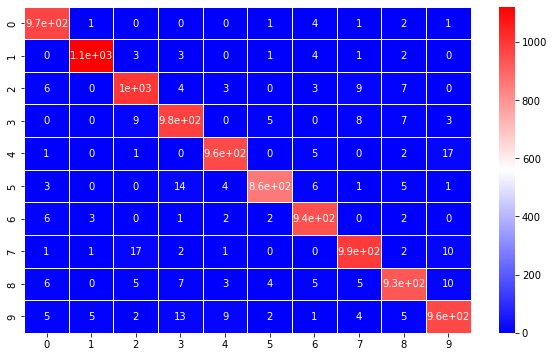

In [ ]:
rf = RandomForestClassifier(n_estimators=300,random_state=1234)
rf.fit(Xtrain, ytrain)
pred = rf.predict(Xval)
correct = accuracy_score(yval, pred)
print('error rate on validation set: {:2.2%}\n'.format(1-correct))

confusion = confusion_matrix(yval, pred)
print("Confusion Matrix:")
print(confusion)
plt.figure(figsize=(10,6))
sns.heatmap(confusion, annot=True, cmap='bwr', linewidths=0.5)
plt.show()

### Random Forest with PCA

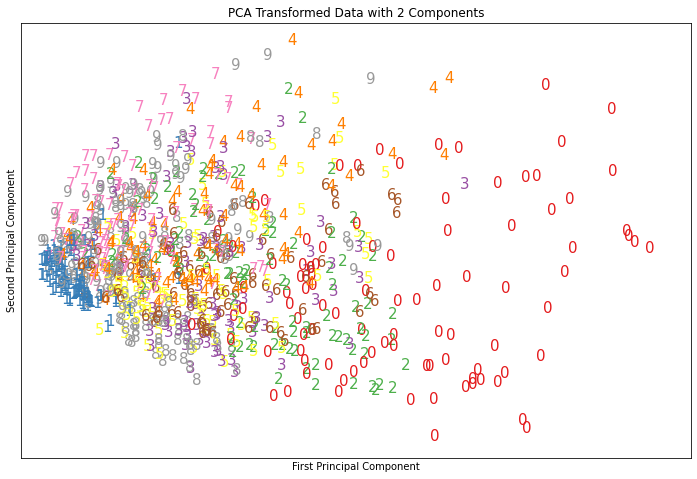

In [ ]:
pca_obj, X_pca = pca_trans(data,2)
plot_components(X_pca[:1000], np.int32(labels[:1000]))

The plot above is the visualization of the pixel data transformed by PCA with 2 components. We can easily see that this transformation did not separate out different labels successfully because the number of components is not enough.

In [ ]:
# PCA transform
# try 50 PCs
k = 50
X = np.concatenate((Xtrain,Xval,Xtest))
pca_obj, X_pca = pca_trans(X,50)

Xtrain_pca = X_pca[0:50000]
Xval_pca = X_pca[50000:60000]
Xtest_pca = X_pca[60000:70000]

rf_pca = RandomForestClassifier(n_estimators=300,random_state=1234)
rf_pca.fit(Xtrain_pca, ytrain)
pred = rf_pca.predict(Xval_pca)
correct = accuracy_score(yval, pred)
print('error rate on validation set: {:2.2%}\n'.format(1-correct))

confusion = confusion_matrix(yval, pred)
print("Confusion Matrix:")
print(confusion)

error rate on validation set: 5.58%

Confusion Matrix:
[[ 965    0    2    2    1    3    5    2    0    0]
 [   0 1121    4    1    1    1    5    0    1    1]
 [  11    0  971   15    3    1    3    9   18    1]
 [   0    0   10  951    1   12    1   15   14    6]
 [   1    1    5    1  928    0    7    6    3   30]
 [   6    0    2   34    5  815    9    4   12    5]
 [   6    3    3    1    4   11  927    0    3    0]
 [   1    8   18    4    7    0    0  958    4   28]
 [   7    0   10   27    7   15    5    8  886    9]
 [   7    6    4   14   29    4    0   19    6  920]]


Using 300 trees in random forest, we find the number of principal components that yields the lowest misclassification rate. 

In [ ]:
error = []
K = range(2,80,5)
for k in K:
    pca_obj,X_pca = pca_trans(X,k)
    Xtrain_pca = X_pca[0:50000]
    Xval_pca = X_pca[50000:60000]
    Xtest_pca = X_pca[60000:70000]
    rf_pca = RandomForestClassifier(n_estimators=300,random_state=1234)
    rf_pca.fit(Xtrain_pca, ytrain)
    pred = rf_pca.predict(Xval_pca)
    correct = accuracy_score(yval, pred)
    error.append(1-correct)

67


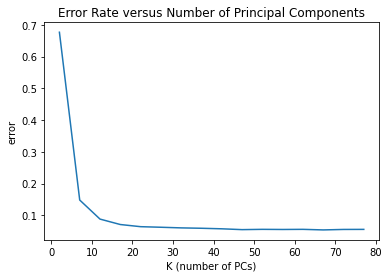

In [ ]:
print(K[np.argmin(error)])
plt.plot(K,error)
plt.xlabel('K (number of PCs)')
plt.ylabel('error')
plt.title("Error Rate versus Number of Principal Components")
plt.show()

Here we choose $k=67$. The following is the model's detailed performance on the data set:

Train data set has 50000 records.
Test data set has 10000 records.
Misclassification rate is 5.55%

Confusion Matrix:
[[ 963    0    4    1    1    4    6    1    0    0]
 [   0 1120    4    2    0    1    5    0    2    1]
 [   9    0  964   22    3    0    6    9   18    1]
 [   0    0   13  951    1   11    1   15   13    5]
 [   1    1    6    1  931    0    9    2    5   26]
 [   7    0    4   30    5  817    9    4   11    5]
 [  10    3    3    0    3   12  924    0    3    0]
 [   0    5   19    4    6    0    0  962    1   31]
 [   5    0   10   26   11   12    4    9  889    8]
 [   7    6    5   14   26    4    0   16    7  924]]


0.9445

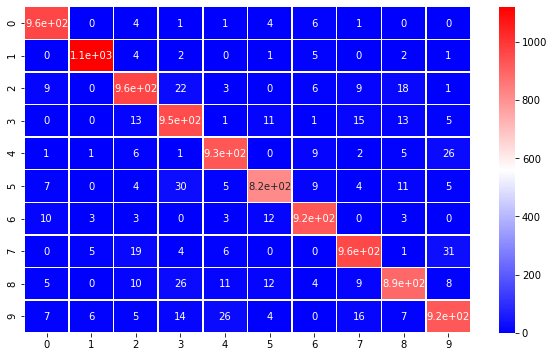

In [ ]:
k=67
X = np.concatenate((Xtrain,Xval,Xtest))
pca_obj,X_pca = pca_trans(X,k)
Xtrain_pca = X_pca[0:50000]
Xval_pca = X_pca[50000:60000]
Xtest_pca = X_pca[60000:70000]
random_forest(Xtrain_pca, ytrain, Xval_pca,yval)

Compared with data without PCA, misclassification rate increases from $2.89\%$ to $5.55\%$, which is acceptable. 

### Logistic Regression

We use the `sklearn.linear` model implementation of multiclass logistic regression. This implementation of logistic regression assumes a regularization term and $C=\frac{1}{\lambda}$. A small regularization term corresponds to very large $C$. 

In [ ]:
lgr = LogisticRegression(fit_intercept=True,C=100000,multi_class='multinomial',solver='lbfgs',max_iter=1000)

lgr.fit(Xtrain,ytrain)
print(f'The mean accuracy on the training data and labels is {lgr.score(Xtrain,ytrain)}.')
print(f'The mean accuracy on the test data and labels is {lgr.score(Xtest,ytest)}.')

The mean accuracy on the training data and labels is 0.94352.
The mean accuracy on the test data and labels is 0.9211.


We try a few $C$’s with a wide range of magnitude to pick the optimal $C$: 

In [ ]:
error = []
C = [100,10,1,0.5,0.2, 0.1,0.05, 0.01]
for c in C:
    lgr = LogisticRegression(fit_intercept=True,C=c,multi_class='multinomial',solver='lbfgs',max_iter=1000)
    # fit the model on training set
    lgr.fit(Xtrain,ytrain)
    error.append(np.sum(lgr.predict(Xval)!=yval)/len(yval))

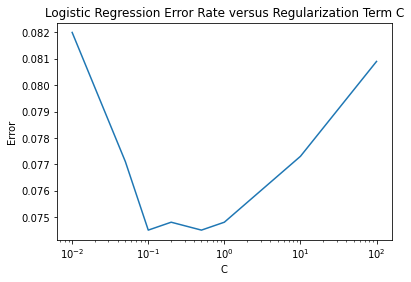

In [ ]:
plt.semilogx(C,error)
plt.xlabel('C')
plt.ylabel('Error')
plt.title("Logistic Regression Error Rate versus Regularization Term C")
plt.show()

Based on the graph above, we pick $C=0.1$ to train the final logistic regression model on the training and validation set together.

In [ ]:
# retrain the model
lgr = LogisticRegression(fit_intercept=True, C=0.1, multi_class='multinomial',solver='lbfgs',max_iter=1000)
lgr.fit(np.concatenate((Xtrain, Xval)), np.concatenate((ytrain, yval)))

LogisticRegression(C=0.1, max_iter=1000, multi_class='multinomial')

In [ ]:
print(f'The mean accuracy on the test data and labels is {lgr.score(Xtest,ytest)} taking C=0.1.')

The mean accuracy on the test data and labels is 0.9291 taking C=0.1.


### Logistic Regression with PCA

In [ ]:
error = []
K = range(30,165,5)
for k in K:
    X = np.concatenate((Xtrain,Xval,Xtest))
    pca_obj,X_pca = pca_trans(X,k)
    Xtrain_pca = X_pca[0:50000]
    Xval_pca = X_pca[50000:60000]
    lgr_pca = LogisticRegression(fit_intercept=True,C=0.01,multi_class='multinomial',solver='lbfgs',max_iter=1000)
    lgr_pca.fit(Xtrain_pca, ytrain)
    error.append(np.sum(lgr_pca.predict(Xval_pca)!=yval)/len(yval))

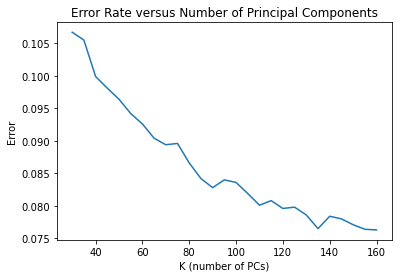

In [ ]:
plt.plot(K,error)
plt.xlabel('K (number of PCs)')
plt.ylabel('Error')
plt.title("Error Rate versus Number of Principal Components")
plt.show()

Based on the error graph, we pick $K=135,C=0.1$ to train the final logistic regression model with PCA projection on the training and validation set together.

In [ ]:
X = np.concatenate((Xtrain,Xval,Xtest))
pca_obj,X_pca = pca_trans(X,135)
Xtrain_pca = X_pca[0:50000]
Xval_pca = X_pca[50000:60000]
Xtest_pca = X_pca[60000:70000]

X_train_val_pca = np.concatenate((Xtrain_pca, Xval_pca))
y_train_val_pca = np.concatenate((ytrain,yval))

lgr_pca = LogisticRegression(fit_intercept=True,C=0.1,multi_class='multinomial',solver='lbfgs')
lgr_pca.fit(X_train_val_pca, y_train_val_pca)
print(f'The mean accuracy on the test data and labels is {lgr_pca.score(Xtest_pca,ytest)} taking C=0.1 and 135 principal components.')

The mean accuracy on the test data and labels is 0.926 taking C=0.1 and 135 principal components.


# Neural Network

In [14]:
data = np.float64(np.load('MNIST_data.npy'))
data = np.float32(data)/255
labels = np.float32(np.load('MNIST_labels.npy'))

Xtrain = data[0:50000]
ytrain = labels[0:50000]
Xval = data[50000:60000]
yval = labels[50000:60000]
Xtest = data[60000:70000]
ytest = labels[60000:70000]

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
Xtrain_cnn = Xtrain.reshape((-1,1,28,28))
ytrain_cnn = np.int32(ytrain)
Xval_cnn = Xval.reshape((-1,1,28,28))
yval_cnn = np.int32(yval)
Xtest_cnn = Xtest.reshape((-1,1,28,28))
ytest_cnn = np.int32(ytest)

train = (Xtrain_cnn,ytrain_cnn)
val = (Xval_cnn,yval_cnn)
test = (Xtest_cnn,ytest_cnn)

In [21]:
pars = par()
pars.__dict__

{'batch_size': 1000,
 'step_size': 0.001,
 'num_epochs': 20,
 'numtrain': 10000,
 'minimizer': 'Adam',
 'data_set': 'mnist',
 'model_name': 'model',
 'dropout': 0.0,
 'dim': 32,
 'pool_size': 2,
 'kernel_size': 5,
 'mid_layer': 256,
 'use_gpu': False}

Here we run 30 epoches on training set to train the neural network model and test on validation set.

In [23]:
# use GPU when possible
pars.device = device
pars.kernel_size = [5,5]
pars.inp_dim = train[0][0].shape

# Initialize the network
net = MNIST_Net(pars).to(pars.device)
# Post it to the gpu if its there.
net.to(pars.device)

train=(train[0][0:pars.numtrain],train[1][0:pars.numtrain])

# run 30 epoches
pars.num_epochs = 30
error_train = []
error_val = []
t0 = time.time()
for i in range(pars.num_epochs):
    # Run one epoch of training
    run_epoch(net,i,train,pars, num=pars.numtrain, ttype="train")
    # Test on validation set.
    net_test(net,val,pars)
t1 = time.time()
time_cnn = t1-t0

conv1 torch.Size([1, 32, 14, 14])
conv2 torch.Size([1, 64, 7, 7])
input dimension to fc1 3136
conv1.weight torch.Size([32, 1, 5, 5])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 5, 5])
conv2.bias torch.Size([64])
fc1.weight torch.Size([256, 3136])
fc1.bias torch.Size([256])
fc_final.weight torch.Size([10, 256])
fc_final.bias torch.Size([10])
tot_pars 857738


  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 0: Avg. loss: 0.0017, Accuracy: 5329/10000 (53.29%), error rate: 46.71% 


Validation set: Avg. loss: 0.0008, Accuracy: 7761/10000 (77.61%), error rate: 22.39% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 1: Avg. loss: 0.0006, Accuracy: 8250/10000 (82.50%), error rate: 17.50% 


Validation set: Avg. loss: 0.0004, Accuracy: 8780/10000 (87.80%), error rate: 12.20% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 2: Avg. loss: 0.0004, Accuracy: 9007/10000 (90.07%), error rate: 9.93% 


Validation set: Avg. loss: 0.0003, Accuracy: 9118/10000 (91.18%), error rate: 8.82% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 3: Avg. loss: 0.0003, Accuracy: 9237/10000 (92.37%), error rate: 7.63% 


Validation set: Avg. loss: 0.0002, Accuracy: 9283/10000 (92.83%), error rate: 7.17% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 4: Avg. loss: 0.0002, Accuracy: 9409/10000 (94.09%), error rate: 5.91% 


Validation set: Avg. loss: 0.0002, Accuracy: 9340/10000 (93.40%), error rate: 6.60% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 5: Avg. loss: 0.0002, Accuracy: 9477/10000 (94.77%), error rate: 5.23% 


Validation set: Avg. loss: 0.0002, Accuracy: 9475/10000 (94.75%), error rate: 5.25% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 6: Avg. loss: 0.0001, Accuracy: 9575/10000 (95.75%), error rate: 4.25% 


Validation set: Avg. loss: 0.0001, Accuracy: 9539/10000 (95.39%), error rate: 4.61% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 7: Avg. loss: 0.0001, Accuracy: 9638/10000 (96.38%), error rate: 3.62% 


Validation set: Avg. loss: 0.0001, Accuracy: 9618/10000 (96.18%), error rate: 3.82% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 8: Avg. loss: 0.0001, Accuracy: 9676/10000 (96.76%), error rate: 3.24% 


Validation set: Avg. loss: 0.0001, Accuracy: 9696/10000 (96.96%), error rate: 3.04% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 9: Avg. loss: 0.0001, Accuracy: 9715/10000 (97.15%), error rate: 2.85% 


Validation set: Avg. loss: 0.0001, Accuracy: 9715/10000 (97.15%), error rate: 2.85% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 10: Avg. loss: 0.0001, Accuracy: 9746/10000 (97.46%), error rate: 2.54% 


Validation set: Avg. loss: 0.0001, Accuracy: 9707/10000 (97.07%), error rate: 2.93% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 11: Avg. loss: 0.0001, Accuracy: 9804/10000 (98.04%), error rate: 1.96% 


Validation set: Avg. loss: 0.0001, Accuracy: 9746/10000 (97.46%), error rate: 2.54% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 12: Avg. loss: 0.0001, Accuracy: 9807/10000 (98.07%), error rate: 1.93% 


Validation set: Avg. loss: 0.0001, Accuracy: 9759/10000 (97.59%), error rate: 2.41% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 13: Avg. loss: 0.0001, Accuracy: 9844/10000 (98.44%), error rate: 1.56% 


Validation set: Avg. loss: 0.0001, Accuracy: 9753/10000 (97.53%), error rate: 2.47% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 14: Avg. loss: 0.0000, Accuracy: 9874/10000 (98.74%), error rate: 1.26% 


Validation set: Avg. loss: 0.0001, Accuracy: 9782/10000 (97.82%), error rate: 2.18% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 15: Avg. loss: 0.0000, Accuracy: 9871/10000 (98.71%), error rate: 1.29% 


Validation set: Avg. loss: 0.0001, Accuracy: 9765/10000 (97.65%), error rate: 2.35% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 16: Avg. loss: 0.0000, Accuracy: 9889/10000 (98.89%), error rate: 1.11% 


Validation set: Avg. loss: 0.0001, Accuracy: 9798/10000 (97.98%), error rate: 2.02% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 17: Avg. loss: 0.0000, Accuracy: 9880/10000 (98.80%), error rate: 1.20% 


Validation set: Avg. loss: 0.0001, Accuracy: 9768/10000 (97.68%), error rate: 2.32% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 18: Avg. loss: 0.0000, Accuracy: 9899/10000 (98.99%), error rate: 1.01% 


Validation set: Avg. loss: 0.0001, Accuracy: 9799/10000 (97.99%), error rate: 2.01% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 19: Avg. loss: 0.0000, Accuracy: 9927/10000 (99.27%), error rate: 0.73% 


Validation set: Avg. loss: 0.0001, Accuracy: 9810/10000 (98.10%), error rate: 1.90% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 20: Avg. loss: 0.0000, Accuracy: 9927/10000 (99.27%), error rate: 0.73% 


Validation set: Avg. loss: 0.0001, Accuracy: 9792/10000 (97.92%), error rate: 2.08% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 21: Avg. loss: 0.0000, Accuracy: 9932/10000 (99.32%), error rate: 0.68% 


Validation set: Avg. loss: 0.0001, Accuracy: 9796/10000 (97.96%), error rate: 2.04% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 22: Avg. loss: 0.0000, Accuracy: 9934/10000 (99.34%), error rate: 0.66% 


Validation set: Avg. loss: 0.0001, Accuracy: 9804/10000 (98.04%), error rate: 1.96% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 23: Avg. loss: 0.0000, Accuracy: 9952/10000 (99.52%), error rate: 0.48% 


Validation set: Avg. loss: 0.0001, Accuracy: 9792/10000 (97.92%), error rate: 2.08% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 24: Avg. loss: 0.0000, Accuracy: 9961/10000 (99.61%), error rate: 0.39% 


Validation set: Avg. loss: 0.0001, Accuracy: 9796/10000 (97.96%), error rate: 2.04% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 25: Avg. loss: 0.0000, Accuracy: 9963/10000 (99.63%), error rate: 0.37% 


Validation set: Avg. loss: 0.0001, Accuracy: 9825/10000 (98.25%), error rate: 1.75% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 26: Avg. loss: 0.0000, Accuracy: 9978/10000 (99.78%), error rate: 0.22% 


Validation set: Avg. loss: 0.0001, Accuracy: 9809/10000 (98.09%), error rate: 1.91% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 27: Avg. loss: 0.0000, Accuracy: 9972/10000 (99.72%), error rate: 0.28% 


Validation set: Avg. loss: 0.0001, Accuracy: 9799/10000 (97.99%), error rate: 2.01% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 28: Avg. loss: 0.0000, Accuracy: 9978/10000 (99.78%), error rate: 0.22% 


Validation set: Avg. loss: 0.0001, Accuracy: 9811/10000 (98.11%), error rate: 1.89% 



  0%|          | 0/10 [00:00<?, ?it/s]


Training set epoch 29: Avg. loss: 0.0000, Accuracy: 9986/10000 (99.86%), error rate: 0.14% 


Validation set: Avg. loss: 0.0001, Accuracy: 9814/10000 (98.14%), error rate: 1.86% 



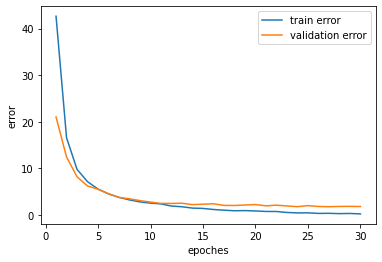

In [ ]:
epoch = np.arange(1, pars.num_epochs+1)
plt.plot(epoch, error_train, label='train error')
plt.plot(epoch, error_val, label='validation error')
plt.xlabel('epoches')
plt.ylabel('error')
plt.title("Errors versus Number of Epoches")
plt.legend()
plt.show()

# Model performance on test data set

## Random Forest Test

In [ ]:
pred = rf.predict(Xtest)
correct = accuracy_score(ytest, pred)
print('error rate of Random Forest on test set: {:2.2%}\n'.format(1-correct))

error rate of Random Forest on test set: 2.68%



## Random Forest with PCA Test

Train data set has 60000 records.
Test data set has 10000 records.
Misclassification rate is 4.85%

Confusion Matrix:
[[ 976    0    4    2    2    0    2    2    3    0]
 [   0 1047    5    4    1    0    5    0    1    1]
 [   3    0  952   11    3    0    3    8    8    2]
 [   1    0   13  968    0   13    1    4   26    4]
 [   0    7    5    0  944    1    1    2    4   19]
 [   5    0    7   36    1  831   18    3    9    5]
 [   3    0    2    0    1    5  953    0    3    0]
 [   4    6    6    9   10    0    0 1038    1   16]
 [   5    9   12   21    1   14    5    4  926   12]
 [   5    2    1   14   20    4    0   30    5  880]]
Error rate of Random Forest with PCA on test set: 4.85%

Time of Random Forest with PCA on test set is 89.68088459968567.


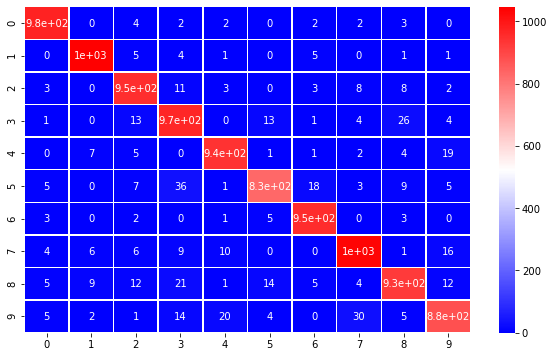

In [ ]:
k=67
X = np.concatenate((Xtrain,Xval,Xtest))
time0=time.time()
pca_obj,X_pca = pca_trans(X,k)
Xtrain_pca = X_pca[0:50000]
Xval_pca = X_pca[50000:60000]
Xtest_pca = X_pca[60000:70000]
correct = random_forest(np.concatenate((Xtrain_pca,Xval_pca)), np.concatenate((ytrain,yval)), Xtest_pca,ytest)
time_pca = time.time()-time0
print('Error rate of Random Forest with PCA on test set: {:2.2%}\n'.format(1-correct))
print(f'Time of Random Forest with PCA on test set is {time_pca} sec.')

## Logistic Regression Test

In [ ]:
time0=time.time()
lgr = LogisticRegression(fit_intercept=True, C=0.1, multi_class='multinomial',solver='lbfgs',max_iter=1000)
lgr.fit(np.concatenate((Xtrain,Xval)), np.concatenate((ytrain,yval)))
time_lr = time.time() -time0
error = np.sum(lgr.predict(Xtest)!=ytest)/len(ytest)
print(f'Error rate of Logistic Regression without PCA on test set: {round(error*100,2)}%')
print(f'Time of Logistic Regression without PCA on test set is {time_lr} sec.')

Error rate of Logistic Regression without PCA on test set: 7.09%
Time of Logistic Regression without PCA on test set is 61.46138000488281 sec.


## Logistic Regression with PCA Test

In [ ]:
k=135
X = np.concatenate((Xtrain,Xval,Xtest))
time0=time.time()
pca_obj,X_pca = pca_trans(X,k)
Xtrain_pca = X_pca[0:50000]
Xval_pca = X_pca[50000:60000]
Xtest_pca = X_pca[60000:70000]
pca_obj,X_pca = pca_trans(X,135)
Xtest_pca = X_pca[60000:70000]
lgr_pca = LogisticRegression(fit_intercept=True, C=0.1, multi_class='multinomial',solver='lbfgs',max_iter=1000)
lgr_pca.fit(np.concatenate((Xtrain_pca,Xval_pca)), np.concatenate((ytrain,yval)))
time_lr = time.time() -time0
error = np.sum(lgr_pca.predict(Xtest_pca)!=ytest)/len(ytest)
print(f'error rate of Logistic Regression with PCA on test set: {round(error*100,2)}%')
print(f'Time of Logistic Regression with PCA on test set is {time_lr} sec.')

error rate of Logistic Regression with PCA on test set: 12.07%
Time of Logistic Regression with PCA on test set is 47.81500864028931 sec.


## Neural Network Test

In [24]:
Xtest_cnn = Xtest.reshape((-1,1,28,28))
ytest_cnn = np.int32(ytest)
test = (Xtest_cnn,ytest_cnn)

In [27]:
net_test(net,test,pars,ttype="test")
print(f'Time of CNN on test set is {time_cnn} sec.')


Test set: Avg. loss: 0.0001, Accuracy: 9816/10000 (98.16%), error rate: 1.84% 

Time of CNN on test set is 11.436894178390503 sec.
